In [1]:
import time
import os
import requests

years = range(1990, 2023)
teams = ["ATL", "BOS", "NJN", "CHA", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND",
         "LAC", "LAL", "MEM", "MIA", "MIL", "MIN", "NOH", "NYK", "OKC", "ORL", "PHI", "PHO",
         "POR", "SAC", "SAS", "TOR", "UTA", "WAS"]

DATA SCRAPING:

In [2]:
url_start_players = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"
for year in years:
    f_path = "players/{}.html".format(year)
    if not os.path.isfile(f_path):
        url_players = url_start_players.format(year)
        data = requests.get(url_players)
    
        with open(f_path, "w+", encoding='utf8') as f:
            f.write(data.text)
    
        time.sleep(1.5)

In [3]:
url_start_teams = "https://www.basketball-reference.com/teams/{}/stats_per_game_totals.html"
for team in teams:
    f_path = "teams/{}.html".format(team)
    if not os.path.isfile(f_path):
        url_teams = url_start_teams.format(team)
        data = requests.get(url_teams)
    
        with open(f_path, "w+", encoding='utf8') as f:
            f.write(data.text)
    
        time.sleep(1.5)

---------------------------------------------------------------------------





DATA CLEANING:

In [4]:
from io import StringIO

from bs4 import BeautifulSoup
import pandas as pd

In [5]:
def clean_theads(b_soup):
    theads = b_soup.find_all('tr', class_="thead")
    for thead in theads:
        thead.decompose()


def remove_cols(b_soup, data_stats):
    thead = b_soup.find_all('th')
    for elem in thead:
        if elem['data-stat'] in data_stats:
            elem.decompose()

    to_remove = b_soup.find_all('td')
    for elem in to_remove:
        if elem['data-stat'] in data_stats:
            elem.decompose()


def clean_partial_tables(b_soup):
    partial_tabs = b_soup.find_all('tr', class_="italic_text partial_table") + b_soup.find_all('tr', class_="italic_text partial_table rowSum")
    while len(partial_tabs) != 0:
        tab = partial_tabs[0]
        next_siblings = [tab.find_next_sibling('tr')]
        previous_sibling = tab.find_previous_sibling('tr')
        i = 0
        while next_siblings[i].find_next_sibling('tr') and str(next_siblings[i].contents[1].contents[0].contents[0]) == str(next_siblings[i].find_next_sibling('tr').contents[1].contents[0].contents[0]):
            next_siblings.append(next_siblings[i].find_next_sibling('tr'))
            i += 1

        games_played_this = int(tab.contents[5].contents[0])
        games_played_next = -1
        next_max_sib = None
        for sib in next_siblings:
            if int(sib.contents[5].contents[0]) > games_played_next:
                games_played_next = int(sib.contents[5].contents[0])
                if next_max_sib:
                    partial_tabs.remove(next_max_sib)
                    next_max_sib.decompose()
                next_max_sib = sib
            else:
                partial_tabs.remove(sib)
                sib.decompose()

        if games_played_this > games_played_next:
            partial_tabs.remove(tab)
            partial_tabs.remove(next_max_sib)
            next_max_sib.decompose()
        else:
            partial_tabs.remove(next_max_sib)
            partial_tabs.remove(tab)
            tab.decompose()

        previous_sibling.decompose()

In [6]:
def clean_players():
    year_data = {}
    for year in years:
        with (open(f"players/{year}.html", encoding='utf8') as f):
            page = f.read()
            soup = BeautifulSoup(page, "html.parser")

            clean_theads(soup)

            clean_partial_tables(soup)

            ds_to_remove = ['age', 'pos', 'gs', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 
                            'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g',
                            'efg_pct']

            remove_cols(soup, ds_to_remove)

            players_tab = soup.find_all(id="per_game_stats")
            players_readed_tab = pd.read_html(StringIO(str(players_tab)))
            year_data.update({year: players_readed_tab[0]})

    return year_data


data_players = clean_players()

In [7]:
def clean_teams():
    year_data = {}
    for team in teams:
        with (open(f"teams/{team}.html", encoding='utf8') as f):
            page = f.read()
            soup = BeautifulSoup(page, "html.parser")

            clean_theads(soup)

            ds_to_remove = ['team_id', 'losses', 'rank_team', 'foo', 'avg_age', 'avg_ht', 'avg_wt', 'mp_per_g', 
                            'fg_per_g', 'fga_per_g', 'fg_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'fg2_per_g', 
                            'fg2a_per_g', 'fg2_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g']

            remove_cols(soup, ds_to_remove)

            teams_tab = soup.find_all(id="stats")
            teams_readed_tab = pd.read_html(StringIO(str(teams_tab)))

            year_data.update({team: teams_readed_tab[0]})

    return year_data


data_teams = clean_teams()

In [8]:
pd.set_option('display.expand_frame_repr', False)
print(data_players[1990])

      Rk             Player   Tm   G  TRB  AST  STL  BLK  TOV   PF   PTS
0      1         Mark Acres  ORL  80  5.4  0.8  0.5  0.3  0.9  3.1   4.5
1      2      Michael Adams  DEN  79  2.8  6.3  1.5  0.0  1.8  1.7  15.5
2      3       Mark Aguirre  DET  78  3.9  1.9  0.4  0.2  1.6  2.6  14.1
3      4        Danny Ainge  SAC  75  4.3  6.0  1.5  0.2  2.5  3.2  17.9
4      5        Mark Alarie  WSB  82  4.6  1.7  0.7  0.5  1.2  2.7  10.5
..   ...                ...  ...  ..  ...  ...  ...  ...  ...  ...   ...
376  377  Orlando Woolridge  LAL  62  3.0  1.5  0.6  0.7  1.2  2.6  12.7
377  378   Haywoode Workman  ATL   6  0.5  0.3  0.5  0.0  0.0  0.5   1.0
378  379      James Worthy*  LAL  80  6.0  3.6  1.2  0.6  2.0  2.4  21.1
379  380        Danny Young  POR  82  1.5  2.8  1.0  0.0  1.0  1.0   4.7
380  381      Michael Young  LAC  45  1.9  0.5  0.6  0.1  0.3  1.0   4.9

[381 rows x 11 columns]


----------------------------------------------------------------------------

WYPEŁNIENIE WARTOŚCI NaN ŚREDNIMI W KOLUMNACH:

In [9]:
for team in teams:
    mean_val = data_teams[team].mean(numeric_only=True)
    rounded_mean = mean_val.round(1)
    data_teams[team] = data_teams[team].fillna(rounded_mean)
    
    
for year in years:
    mean_val = data_players[year].mean(numeric_only=True)
    rounded_mean = mean_val.round(1)
    data_players[year] = data_players[year].fillna(rounded_mean)

-------------------------------------------------------------------------
DODANIE KOLUMNY Z PROCENTEM WYGRANYCH:

In [10]:
for team in teams:
    data_teams[team]['win_percentage'] = round(data_teams[team]['W'] / data_teams[team]['G'], 3)

-------------------------------------------------------------------------
ANALIZA WPŁYWU POSZCZEGÓLNYCH STATYSTYK NA WYNIK ZESPOŁU

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [12]:
pd.set_option('display.expand_frame_repr', False)
# print(data_teams['SAS'])

independent_vars = ['TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
def get_results_lin(teams_data):
    coefficients = []
    bs = []
    Y_preds = []
    X_tests = []
    for team in teams:
        t_data = teams_data[team]
        X = t_data[independent_vars]
        Y = t_data['win_percentage']
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        # mse_lin_train = mean_squared_error(Y_train, model.predict(X_train))
        # print(f'Mean squared error train (lin): {mse_lin_train:0.3}\n')
        mse_lin = mean_squared_error(Y_test, Y_pred)
        print(f'Team name: {team}')
        print(f'Mean squared error (lin): {mse_lin:0.3}\n')
        
        coefficients.append(model.coef_)
        bs.append(model.intercept_)
        Y_preds.append(Y_pred)
        X_tests.append(X_test)
        
        
    coeff_df = pd.DataFrame(coefficients, columns=independent_vars)
    
    return coeff_df, Y_preds, X_tests, bs

coeffs_df_lin, Y_preds_lin, X_tests_lin, bs_lin = get_results_lin(data_teams)
mean_coeffs_lin = coeffs_df_lin.mean()
print("Średnie współczynniki regresji dla całej ligi:")
print(mean_coeffs_lin)

Team name: ATL
Mean squared error (lin): 0.00956

Team name: BOS
Mean squared error (lin): 0.0035

Team name: NJN
Mean squared error (lin): 0.0117

Team name: CHA
Mean squared error (lin): 0.014

Team name: CHI
Mean squared error (lin): 0.0192

Team name: CLE
Mean squared error (lin): 0.0118

Team name: DAL
Mean squared error (lin): 0.0216

Team name: DEN
Mean squared error (lin): 0.0142

Team name: DET
Mean squared error (lin): 0.0173

Team name: GSW
Mean squared error (lin): 0.0135

Team name: HOU
Mean squared error (lin): 0.0131

Team name: IND
Mean squared error (lin): 0.0102

Team name: LAC
Mean squared error (lin): 0.0124

Team name: LAL
Mean squared error (lin): 0.0182

Team name: MEM
Mean squared error (lin): 0.00831

Team name: MIA
Mean squared error (lin): 0.0159

Team name: MIL
Mean squared error (lin): 0.00958

Team name: MIN
Mean squared error (lin): 0.00662

Team name: NOH
Mean squared error (lin): 0.0117

Team name: NYK
Mean squared error (lin): 0.0176

Team name: OKC
Me

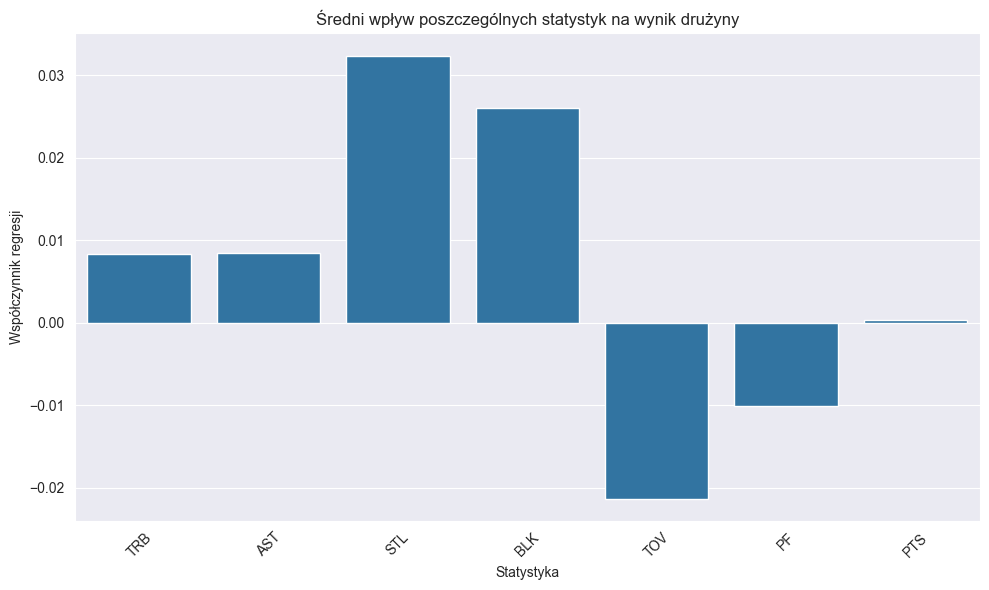

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_coeffs_lin.index, y=mean_coeffs_lin.values)
plt.title('Średni wpływ poszczególnych statystyk na wynik drużyny')
plt.xlabel('Statystyka')
plt.ylabel('Współczynnik regresji')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('barplot.jpg', transparent=True)
plt.show()

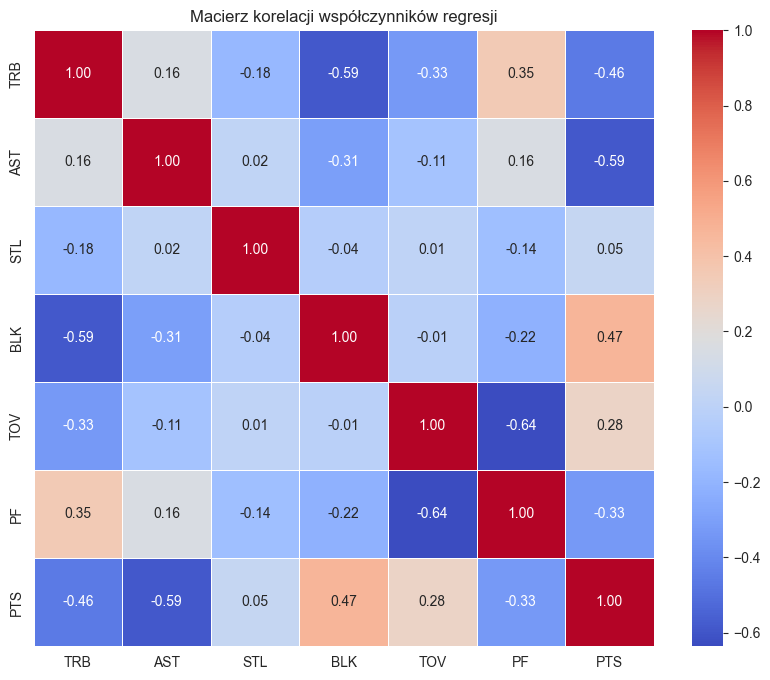

In [16]:
corr_matrix = coeffs_df_lin.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Macierz korelacji współczynników regresji')
plt.savefig('corr.jpg', transparent=True)
plt.show()

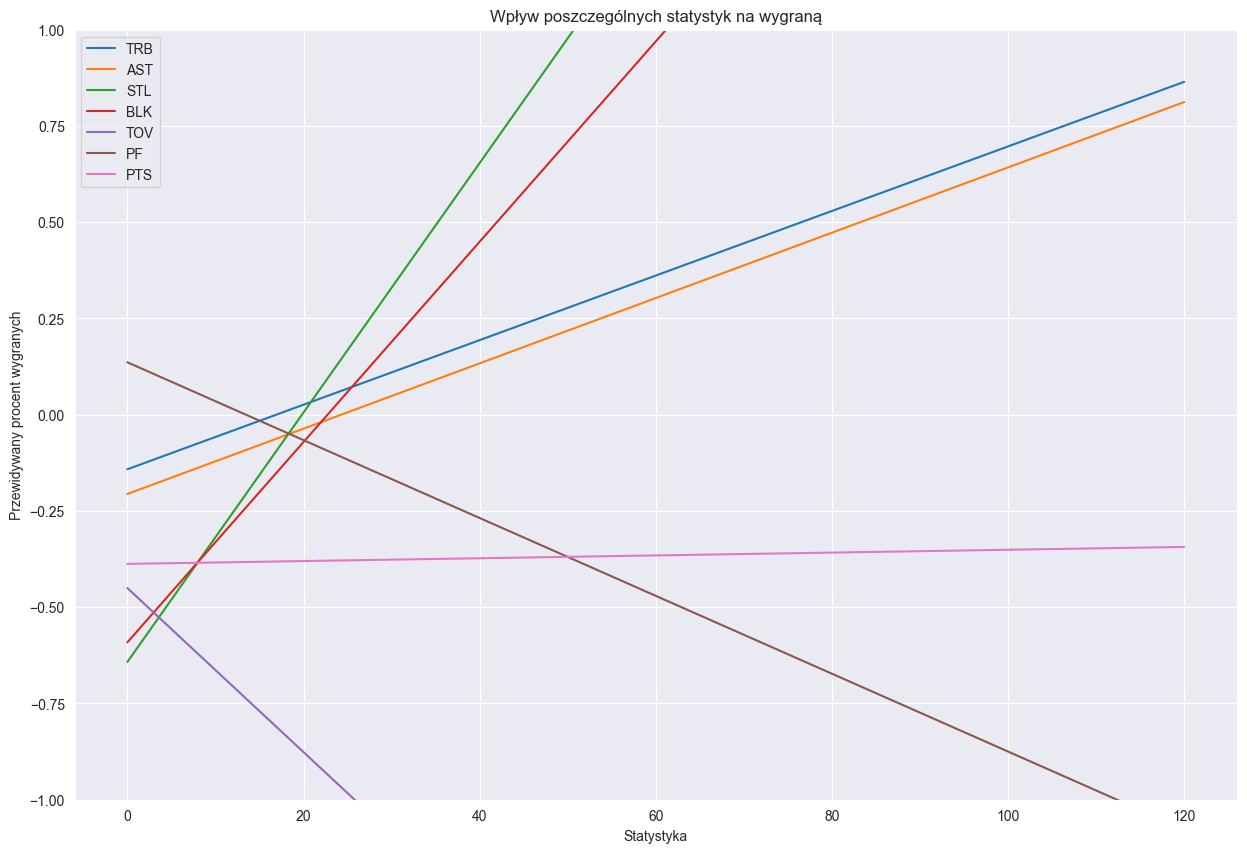

In [17]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(independent_vars):
    a = mean_coeffs_lin.iloc[i]
    b = bs_lin[i]
    x_range = np.linspace(0, 120, 100)
    y_range = a * x_range + b
    
    plt.plot(x_range, y_range, label=col)
plt.title('Wpływ poszczególnych statystyk na wygraną')
plt.xlabel('Statystyka')
plt.ylabel('Przewidywany procent wygranych')
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.savefig('reg_analiza.jpg', transparent=True)
plt.show()

----------------------------------------------------------------------------------------------
SPOSÓB 1 - OBLICZENIE WPŁYWU ZAWODNIKA NA PODSTAWIE ŚREDNICH WSPÓŁCZYNNIKÓW REGRESJI LINIOWEJ:

In [18]:
def calculate_player_impact(player_stats):
    impact = sum(mean_coeffs_lin[stat] * player_stats[stat] for stat in independent_vars)
    return impact


def get_team_players(players_data, year, team):
    year_data = (players_data[year])
    team_players = year_data[year_data['Tm'] == team]
    
    return team_players


def get_changes(players_data, year, team):
    if year not in range(1991, 2023):
        raise ValueError(f"Year {year} is out of range")
    prev_year = year - 1
    
    prev_team = get_team_players(players_data, prev_year, team)
    this_team = get_team_players(players_data, year, team)
    
    incoming_players = this_team[~this_team['Player'].isin(prev_team['Player'])]
    outgoing_players = prev_team[~prev_team['Player'].isin(this_team['Player'])]
    
    return incoming_players, outgoing_players


def predict_season_outcome(changes):
    season_win_percentage_change = sum(calculate_player_impact(row) for index, row in changes[0].iterrows()) - sum(calculate_player_impact(row) for index, row in changes[1].iterrows())
    return season_win_percentage_change


def get_season(year):
    previous_year = year - 1
    season = f"{previous_year}-{str(year)[2:]}"
    
    return season


def calc_changes_diff(changes, team, actual_pct, prev_pct):
    incoming_sum = changes[0].select_dtypes(include='number').sum()
    outgoing_sum = changes[1].select_dtypes(include='number').sum()
    
    stats_diff = incoming_sum - outgoing_sum
    stats_diff['year'] = actual_pct
    stats_diff['prev_year'] = prev_pct
    stats_diff['team'] = team
    return stats_diff


all_changes = []
pred_changes = []
actual_changes = []
for team in teams:
    t_data = data_teams[team]
    start_season = 1991 if team not in ['MEM', 'NOH'] else (2004 if team == 'NOH' else 1997)
    for year in range(start_season, 2023):
        year_row = t_data[t_data['Season'] == get_season(year)]
        prev_year_row = t_data[t_data['Season'] == get_season(year - 1)]
        if len(year_row) != 0 and len(prev_year_row) != 0:
            actual_percentage = year_row['win_percentage'].iloc[0]
            prev_win_percentage = prev_year_row['win_percentage'].iloc[0]
            actual_changes.append(actual_percentage - prev_win_percentage)
            team_changes = get_changes(data_players, year, team)
            
            predicted_percentage = predict_season_outcome(team_changes)
            pred_changes.append(predicted_percentage)
            
            changes_diff = calc_changes_diff(team_changes, team, actual_percentage, prev_win_percentage)
            all_changes.append(changes_diff)
        
        
years_percentage_df = pd.DataFrame({'Rzeczywista zmiana procentu wygranych': actual_changes,
                                    'Przewidywana zmiana procentu wygranych': pred_changes})
print(years_percentage_df)

mse = mean_squared_error(actual_changes, pred_changes)
print(f'Mean squared error (lin merged): {mse:0.3}\n')

     Rzeczywista zmiana procentu wygranych  Przewidywana zmiana procentu wygranych
0                                    0.024                               -0.090096
1                                   -0.061                                0.033506
2                                    0.061                               -0.017132
3                                    0.171                                0.063476
4                                   -0.183                               -0.007956
..                                     ...                                     ...
927                                 -0.074                                0.102146
928                                 -0.134                                0.229795
929                                 -0.043                               -0.278043
930                                  0.125                                0.160398
931                                 -0.045                                0.105385

[93

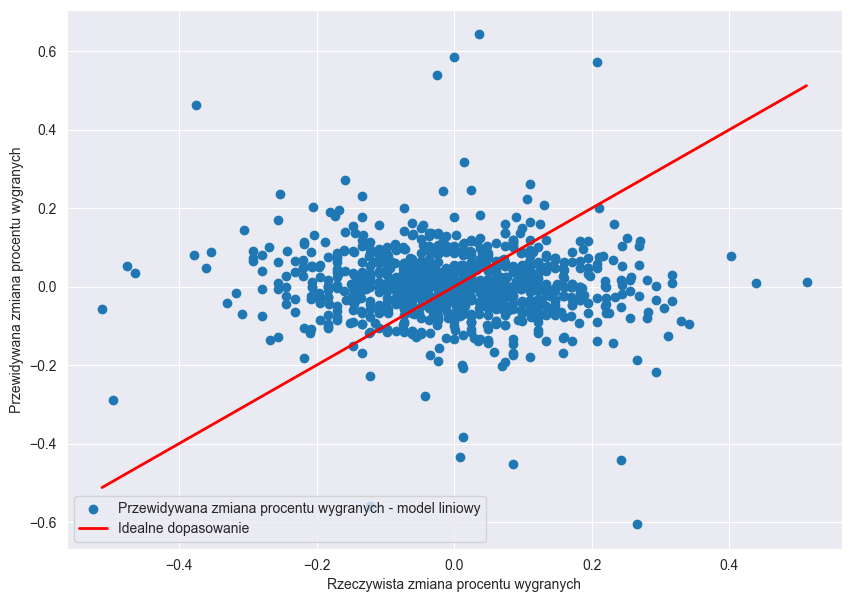

In [19]:
x_axis = np.arange(len(actual_changes))[::8]

plt.figure(figsize=(10,7))
plt.scatter(actual_changes, pred_changes, label='Przewidywana zmiana procentu wygranych - model liniowy')
plt.plot([min(actual_changes), max(actual_changes)], [min(actual_changes), max(actual_changes)], color='red', lw=2, label='Idealne dopasowanie')

plt.legend()
plt.xlabel('Rzeczywista zmiana procentu wygranych')
plt.ylabel('Przewidywana zmiana procentu wygranych')
plt.savefig('linear_model.jpg', transparent=True)
plt.show()

-------------------------------------------------------------------------
SPOSÓB 2 - BEZPOŚREDNIE TRENOWANIE MODELU NA ZMIANACH W DRUŻYNACH

In [20]:
from sklearn.svm import SVR

all_changes_df = pd.DataFrame(all_changes)
X = all_changes_df[independent_vars]
Y = all_changes_df['prev_year'] - all_changes_df['year']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

pd.set_option('display.expand_frame_repr', False)
print(all_changes_df)


model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_lin_merged = model.predict(X_test)

# mse_lin_train = mean_squared_error(Y_train, model.predict(X_train))
# print(f'Mean squared error train (lin merged): {mse_lin_train:0.3}\n')

mse_lin = mean_squared_error(Y_test, Y_pred_lin_merged)
print(f'Mean squared error (lin merged): {mse_lin:0.3}\n')


model_SVR = SVR(kernel='rbf', gamma='scale', C=1)

model_SVR.fit(X_train, Y_train)
Y_pred_svm = model_SVR.predict(X_test)

# mse_svr_train = mean_squared_error(Y_train, model_SVR.predict(X_train))
# print(f'Mean squared error train (lin): {mse_svr_train:0.3}\n')

mse_svr = mean_squared_error(Y_test, Y_pred_svm)
print(f'Mean squared error (svm): {mse_svr:0.3}\n')

         Rk      G   TRB  AST  STL  BLK  TOV   PF   PTS   year  prev_year team
0    -280.0  -66.0  -4.3 -5.9 -1.4 -0.8 -0.8 -5.1 -17.5  0.524      0.500  ATL
1     291.0   -1.0   2.1  2.7  1.6  0.0  0.7  4.4   1.5  0.463      0.524  ATL
2   -1000.0  -38.0   2.3 -3.8 -1.1  0.2 -1.1 -0.5  -6.1  0.524      0.463  ATL
3    -153.0   90.0  -1.7  1.8  0.6  0.4 -0.6 -1.9   1.7  0.695      0.524  ATL
4     260.0  113.0   0.2  3.3  1.3  0.6  1.7  5.7  -4.1  0.512      0.695  ATL
..      ...    ...   ...  ...  ...  ...  ...  ...   ...    ...        ...  ...
927   504.0   79.0   6.8  4.8  1.4  0.2  1.2  2.4  10.0  0.524      0.598  WAS
928   542.0   -1.0  22.0  5.0  3.7  1.7  4.5  8.1  45.1  0.390      0.524  WAS
929  -197.0  -14.0 -18.1 -9.6 -4.0 -1.5 -5.4 -2.1 -34.0  0.347      0.390  WAS
930  -492.0  190.0  16.3  6.9  1.6  0.5  4.3  1.4  16.6  0.472      0.347  WAS
931  -209.0   24.0  -5.0 -6.2 -0.2 -0.2 -7.4 -5.0   9.2  0.427      0.472  WAS

[932 rows x 12 columns]
Mean squared error (lin mer

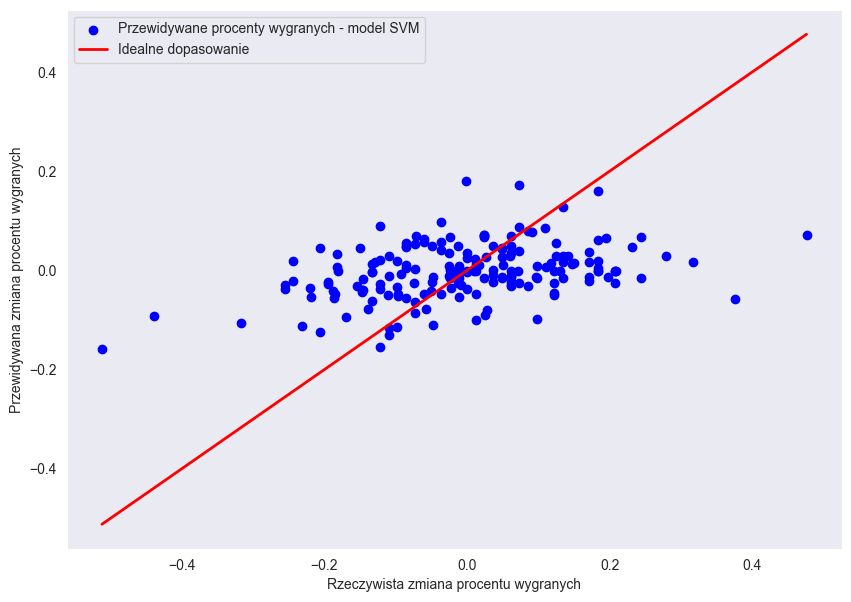

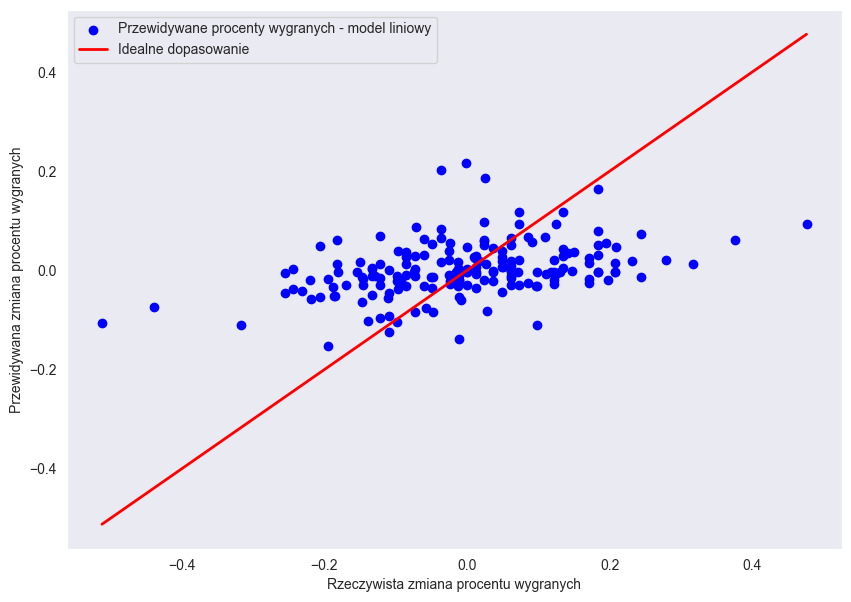

In [21]:
plt.figure(figsize=(10,7))

os_x = np.linspace(0, 120, 305)
plt.scatter(Y_test, Y_pred_svm, color='blue', label='Przewidywane procenty wygranych - model SVM')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', lw=2, label='Idealne dopasowanie')

plt.xlabel('Rzeczywista zmiana procentu wygranych')
plt.ylabel('Przewidywana zmiana procentu wygranych')
plt.legend()
plt.grid()
plt.savefig('svm_model.jpg', transparent=True)
plt.show()


plt.figure(figsize=(10,7))

plt.scatter(Y_test, Y_pred_lin_merged, color='blue', label='Przewidywane procenty wygranych - model liniowy')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', lw=2, label='Idealne dopasowanie')

plt.xlabel('Rzeczywista zmiana procentu wygranych')
plt.ylabel('Przewidywana zmiana procentu wygranych')
plt.legend()
plt.grid()
plt.savefig('linear_model_merged.jpg', transparent=True)
plt.show()